In [201]:
import json
from datetime import datetime
import pandas as pd

# importing the csv data about the store sales, 906 stores with 11936 timestamps.
raw_csv = pd.read_csv('sales_granular.csv', index_col=0)

# importing the surroundings information about some 546 stores, each with 89 possible types of surroundings.
raw = json.load(open('Surroundings.json'))


# manual inspection of JSON file by writing a single item in the list to disk.
with open('extract.json', 'w') as outfile:
    json.dump(raw[0], outfile)


In [196]:
def group_by_month(timestamp_str):
    
    space_idx = timestamp_str.find(' ')
    parse_date_string = timestamp_str[:space_idx]
    
    date_datetime = datetime.strptime(parse_date_string, '%m/%d/%y')

    if len(str(date_datetime.month)) == 1:
        mm = '0' + str(date_datetime.month)
    else:
        mm = str(date_datetime.month)
        
    yyyy = str(date_datetime.year)
    
    month_key = '{0}-{1}'.format(yyyy, mm)
    return month_key

In [203]:
## aggregated all the sales data per month based on the column names.
## sorted key list now contains indices per corresponsing month, used later for plotting and regressions.
# first get the column names
atomic_timestamps = list(raw_csv)

month_dict = {}

for idx, col_timestamp in enumerate(atomic_timestamps):
    current_month = group_by_month(col_timestamp)
    
    if month_dict.has_key(current_month):
        month_dict[current_month].append(idx)
    else:
        month_dict[current_month] = []
        month_dict[current_month].append(idx)

sorted_key_list = sorted(month_dict.keys())
print(sorted_key_list)

['2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06']


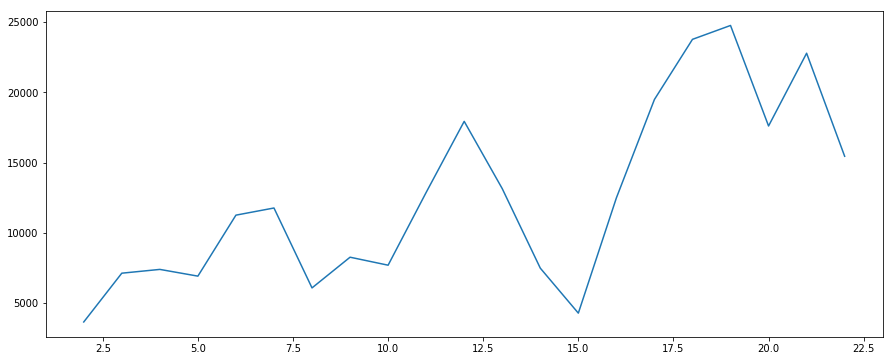

In [267]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6


# raw_csv[month_dict['2015-08']]
for i in range(9, len(raw_csv.index)):
    plot_array = []
    for _, key in enumerate(sorted_key_list):
        plot_array.append(raw_csv.iloc[i][month_dict[key][0]:month_dict[key][-1]].sum(skipna=True))
        
        # print(key, " : ", raw_csv.iloc[i][month_dict[key][0]:month_dict[key][-1]].sum(skipna=True))

    plt.plot(plot_array)
    plt.show()
    # print(raw_csv.iloc[i][month_dict[key][0]:month_dict[key][-1]].describe())
    print('\n\n')
    break

In [252]:
len(raw_csv.index)

906

In [245]:
raw_csv.describe()

,8/3/15 9:00,8/3/15 10:00,8/3/15 11:00,8/3/15 12:00,8/3/15 13:00,8/3/15 14:00,8/3/15 15:00,8/3/15 16:00,8/3/15 17:00,8/3/15 18:00,...,6/25/17 13:00,6/25/17 14:00,6/25/17 15:00,6/25/17 16:00,6/25/17 17:00,6/25/17 18:00,6/25/17 19:00,6/25/17 20:00,6/25/17 21:00,6/25/17 22:00
count,1.0,5.000000,1.0,2.0,6.000000,2.0,4.000000,4.000000,3.000000,3.000000,...,38.000000,36.000000,51.000000,50.000000,36.000000,38.000000,35.000000,26.000000,18.000000,3.000000
mean,300.0,570.000000,150.0,150.0,180.000000,300.0,390.000000,262.500000,480.000000,230.000000,...,91.578947,90.833333,172.941176,111.600000,105.000000,103.421053,100.285714,73.846154,90.000000,120.000000
std,NaN,268.328157,NaN,0.0,158.745079,0.0,106.770783,143.614066,158.745079,192.873015,...,99.363551,89.709850,286.218756,137.549397,102.302074,157.313189,128.303081,89.490868,108.410983,155.884573
min,300.0,300.000000,150.0,150.0,0.000000,300.0,300.000000,150.000000,300.000000,90.000000,...,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
25%,300.0,300.000000,150.0,150.0,150.000000,300.0,300.000000,150.000000,420.000000,120.000000,...,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
50%,300.0,600.000000,150.0,150.0,150.000000,300.0,375.000000,225.000000,540.000000,150.000000,...,45.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,30.000000,30.000000,30.000000
75%,300.0,750.000000,150.0,150.0,150.000000,300.0,465.000000,337.500000,570.000000,300.000000,...,90.000000,97.500000,300.000000,112.500000,97.500000,90.000000,90.000000,60.000000,82.500000,165.000000
max,300.0,900.000000,150.0,150.0,480.000000,300.0,510.000000,450.000000,600.000000,450.000000,...,330.000000,300.000000,1890.000000,600.000000,330.000000,900.000000,600.000000,390.000000,360.000000,300.000000


In [160]:
## important step for analysis is to group the sales per office in a monthly group

class StoreSalesMonth():
    
    def __init__(self):
        
        # timestamp property
        self.timestamp_components_number = 0        
        self.timestamp_component_sales_array = []
        
        # date property
        self.current_month = 0
        self.current_date_string = ''
        self.current_date_datetime = None
        
    def TotalMonthlySales(self):
        return sum(self.timestamp_component_sales_array)
        

store_sales_array = []
        

# first get the column names
atomic_timestamps = list(raw_csv)

current_month = None
timestamp_count

# instanciate StoreSalesMonth object
store_monthly_sales_obj = StoreSalesMonth()

# currently working with a single store (the first one!)
for idx, raw_date in enumerate(atomic_timestamps[0]):

    space_idx = raw_date.find(' ')
        
    store_monthly_sales_obj.current_date_string = raw_date[:space_idx]
    store_monthly_sales_obj.current_date_datetime = datetime.strptime(store_monthly_sales_obj.current_date, '%m/%d/%y')
    store_monthly_sales_obj.current_month = store_monthly_sales_obj.current_date_datetime.month
    
    if current_month == None:
        current_month = store_monthly_sales_obj.current_month
        store_monthly_sales_obj.timestamp_components_number += 1
        store_monthly_sales_obj.timestamp_component_sales_array.append(raw_csv[raw_date][idx])
        continue
        
    else:
        current_date_string = raw_date[:space_idx]
        current_month = datetime.strptime(current_date_string, '%m/%d/%y').month
        
        if current_month
        
        

8

In [87]:
# !which python
# !pip install pandas
# !pip install scipy
# !pip install NumPy
# !pip install Matplotlib
# !pip install scikit-learn
# !pip install statsmodels

    100% |████████████████████████████████| 16.8MB 68kB/s  eta 0:00:01
    100% |████████████████████████████████| 13.2MB 92kB/s  eta 0:00:01
    100% |████████████████████████████████| 61kB 7.0MB/s eta 0:00:01
    100% |████████████████████████████████| 61kB 8.2MB/s eta 0:00:01
  Running setup.py bdist_wheel for subprocess32 ... done
  Stored in directory: /Users/admin/Library/Caches/pip/wheels/7d/4c/a4/ce9ceb463dae01f4b95e670abd9afc8d65a45f38012f8030cc
Successfully built subprocess32
    100% |████████████████████████████████| 8.0MB 152kB/s eta 0:00:01
    100% |████████████████████████████████| 5.4MB 215kB/s eta 0:00:01
    100% |████████████████████████████████| 235kB 4.6MB/s eta 0:00:01


In [ ]:
import pandas as pd
raw_csv = pd.read_csv('sales_granular.csv', index_col=0)

In [ ]:
raw_csv[:25]
raw_csv.count()
raw_csv.index

In [ ]:
# 11936 columns 
# 906 rows (stores)

In [ ]:
# has 546 elements in json
len(raw)

In [ ]:
raw[1].keys()

In [ ]:
print(len(list(raw_csv.index)))
print(len(tuple(raw_csv.index)))

In [48]:
raw[0].keys()

[u'surroundings', u'store_code']

In [58]:
raw[2]['surroundings']['beauty_salon'][3].keys()[0].encode('utf-8')

'rating'

In [71]:
with open('extract.json', 'w') as outfile:
    json.dump(raw[0], outfile)

In [84]:
for surr_type in raw[2]['surroundings'].keys():
    print(surr_type.encode('utf8'))

subway_station
department_store
embassy
beauty_salon
police
courthouse
cemetery
pharmacy
local_government_office
shopping_mall
city_hall
rv_park
shoe_store
bank
bowling_alley
bar
university
car_dealer
taxi_stand
fire_station
church
convenience_store
campground
lawyer
parking
post_office
hindu_temple
hardware_store
meal_takeaway
movie_rental
gas_station
funeral_home
aquarium
restaurant
home_goods_store
atm
veterinary_care
airport
locksmith
bus_station
hospital
night_club
electrician
mosque
amusement_park
lodging
florist
liquor_store
museum
car_rental
stadium
store
hair_care
transit_station
meal_delivery
gym
park
dentist
library
book_store
painter
roofing_contractor
moving_company
clothing_store
furniture_store
physiotherapist
casino
art_gallery
car_wash
movie_theater
spa
accounting
cafe
car_repair
synagogue
real_estate_agency
electronics_store
doctor
bicycle_store
storage
zoo
train_station
jewelry_store
laundry
insurance_agency
plumber
pet_store
bakery
travel_agency


In [89]:
train = [1,2,3,4,5]
history = [x for x in train]
history[-1]


5

In [95]:
len(list(raw_csv))

11936

In [118]:
[x[0] for x in list(raw_csv)]
obs_counter = 0
for _, entries_per_month in enumerate(list(raw_csv)):
    if entries_per_month[0] == '3' and entries_per_month[5] == '6' :
        obs_counter += 1
        print(entries_per_month)

obs_counter



3/1/16 6:00
3/1/16 7:00
3/1/16 8:00
3/1/16 9:00
3/1/16 10:00
3/1/16 11:00
3/1/16 12:00
3/1/16 13:00
3/1/16 14:00
3/1/16 15:00
3/1/16 16:00
3/1/16 17:00
3/1/16 18:00
3/1/16 19:00
3/1/16 20:00
3/1/16 21:00
3/1/16 22:00
3/1/16 23:00
3/2/16 6:00
3/2/16 7:00
3/2/16 8:00
3/2/16 9:00
3/2/16 10:00
3/2/16 11:00
3/2/16 12:00
3/2/16 13:00
3/2/16 14:00
3/2/16 15:00
3/2/16 16:00
3/2/16 17:00
3/2/16 18:00
3/2/16 19:00
3/2/16 20:00
3/2/16 21:00
3/2/16 22:00
3/3/16 5:00
3/3/16 6:00
3/3/16 7:00
3/3/16 8:00
3/3/16 9:00
3/3/16 10:00
3/3/16 11:00
3/3/16 12:00
3/3/16 13:00
3/3/16 14:00
3/3/16 15:00
3/3/16 16:00
3/3/16 17:00
3/3/16 18:00
3/3/16 19:00
3/3/16 20:00
3/3/16 21:00
3/3/16 22:00
3/4/16 5:00
3/4/16 6:00
3/4/16 7:00
3/4/16 8:00
3/4/16 9:00
3/4/16 10:00
3/4/16 11:00
3/4/16 12:00
3/4/16 13:00
3/4/16 14:00
3/4/16 15:00
3/4/16 16:00
3/4/16 17:00
3/4/16 18:00
3/4/16 19:00
3/4/16 20:00
3/4/16 21:00
3/4/16 22:00
3/4/16 23:00
3/5/16 5:00
3/5/16 7:00
3/5/16 8:00
3/5/16 9:00
3/5/16 10:00
3/5/16 11:00
3/5/16 1

154

In [138]:
space_idx = list(raw_csv)[100].find(' ')
date = list(raw_csv)[100][:space_idx]
date

'8/10/15'

In [139]:
!pip install timestring
import timestring

    100% |████████████████████████████████| 204kB 3.8MB/s ta 0:00:011
  Running setup.py bdist_wheel for timestring ... done
  Stored in directory: /Users/admin/Library/Caches/pip/wheels/e7/b1/ed/3d4af5e291317fece730287af21f5665d4ab8914baf35b231a
  Running setup.py bdist_wheel for pytz ... done
  Stored in directory: /Users/admin/Library/Caches/pip/wheels/74/c2/e0/afa37db89f151c13e60a0fabfb304523dc7a6b398c19200094
Successfully built timestring pytz
  Found existing installation: pytz 2017.3
    Uninstalling pytz-2017.3:
      Successfully uninstalled pytz-2017.3


In [146]:
timestring.Date('25/12/2015')
import time


In [148]:
!pip install datetime
import datetime

In [157]:
from datetime import datetime
datetime.strptime('12/25/15', '%m/%d/%y')

datetime.datetime(2015, 12, 25, 0, 0)